#### MOUNT

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 라이브러리 불러오기

In [5]:
import tensorboard

In [6]:
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

from torchvision import transforms, datasets

# 1. 데이터셋 정리(전처리)

In [32]:
dir_data ='./dataset'

#### HGG 파일 내의 데이터를 input, label로 분류해서 dataset 안에 정리

In [33]:
%pwd

'/content'

In [34]:
import random

# 실행 환경에 맞게 dataset path, hgg path 변경 필요
# './drive/MyDrive/MICCIC_BraTS_2019_Data_Training'
dataset_path = './drive/MyDrive/MICCAI_BraTS_2019_Data_Training'
hgg_path = dataset_path + "/HGG"


filename = os.listdir(hgg_path)
# fielname = random.shuffle(filename)
# shuffle(filename) # 모두가 같은 데이터를 사용해야하기 때문에 셔플 제거
filename = filename[:5]
filecount = len(filename)
HGG1 = round(filecount*0.6)
HGG2 = round(filecount*0.8)

In [35]:
# !pip install nibabel

In [36]:
import nibabel as nib

In [50]:
# 주의사항: data types, file names의 train, val, test 순서를 잘 맞추자!!
data_types = ["train", "val", "test"]

original_file_train = filename[:HGG1] #Htrain
original_file_val = filename[HGG1:HGG2] #Val
original_file_test = filename[HGG2:] #Test
original_files = [original_file_train, original_file_val, original_file_test]

dir_save_train = os.path.join(dir_data, 'train')

# Train, Val, Test 저장
for data_type, original_file in zip(data_types, original_files):
  dir_save = os.path.join(dir_data, data_type)
  if os.path.exists(dir_save): # 이미 파일이 있다면 더 진행하지 않음
    print(dir_save,"폴더가 이미 존재함")
    continue
  os.makedirs(dir_save)

  i = 0
  for current_data in original_file:
    if current_data[0] == ".":
      continue
    i+=1
    for b in os.listdir(os.path.join(hgg_path, current_data)):
      if 'seg' in b:
        img_label = nib.load(os.path.join(hgg_path,current_data, b)).get_fdata()
        label_= np.array(img_label)
        np.save(os.path.join(dir_save, 'label_%03d.npy' % (4*i-3)),label_)
        np.save(os.path.join(dir_save, 'label_%03d.npy' % (4*i-2)),label_)
        np.save(os.path.join(dir_save, 'label_%03d.npy' % (4*i-1)),label_)
        np.save(os.path.join(dir_save, 'label_%03d.npy' % (4*i)),label_)
      elif 'flair' in b:
        img_input = nib.load(os.path.join(hgg_path,current_data, b)).get_fdata()
        input_ = np.array(img_input)
        np.save(os.path.join(dir_save, 'input_%03d.npy' % (4*i-3)),input_)
      elif 't2' in b:
        img_input = nib.load(os.path.join(hgg_path,current_data, b)).get_fdata()
        input_ = np.array(img_input)
        np.save(os.path.join(dir_save, 'input_%03d.npy' % (4*i-2)),input_)
      elif 't1ce' in b:
        img_input = nib.load(os.path.join(hgg_path,current_data, b)).get_fdata()
        input_ = np.array(img_input)
        np.save(os.path.join(dir_save, 'input_%03d.npy' % (4*i-1)),input_)
      else :
        img_input = nib.load(os.path.join(hgg_path,current_data, b)).get_fdata()
        input_ = np.array(img_input)
        np.save(os.path.join(dir_save, 'input_%03d.npy' % (4*i)),input_)

  print(dir_save,"처리 완료")

./dataset/train 폴더가 이미 존재함
./dataset/val 폴더가 이미 존재함
./dataset/test 폴더가 이미 존재함


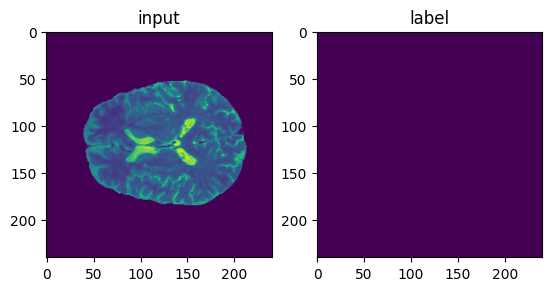

In [57]:
## 이미지 시각화(input)
plt.subplot(122)
plt.imshow(label_[:,:,77])
plt.title('label')

plt.subplot(121)
plt.imshow(input_[:,:,77])
plt.title('input')

plt.show()

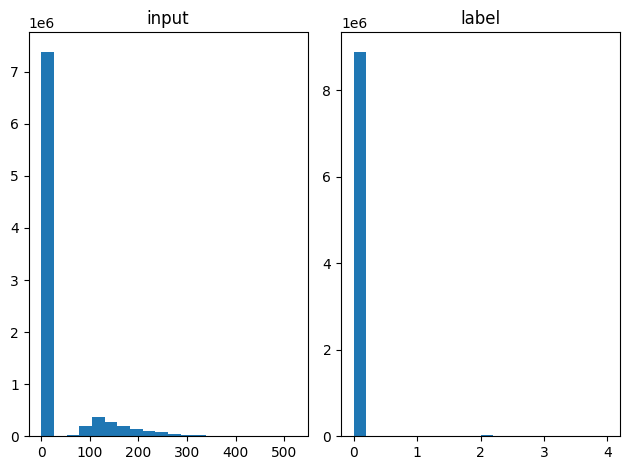

In [58]:
## 한 이미지의 분포
plt.subplot(122)
plt.hist(label_.flatten(), bins=20)
plt.title('label')

plt.subplot(121)
plt.hist(input_.flatten(), bins=20)
plt.title('input')

plt.tight_layout()
plt.show()

# 2. 3D 네트워크 구축하기

In [8]:
## 라이브러리 불러오기
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

from torchvision import transforms, datasets

## 네트워크 구축하기
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Convolution + BatchNormalization + Relu 정의하기
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)
            # nn.Sequential 클래스 : nn.ReLU 등의 모듈들을 인수로 받아서 순서대로 정렬해놓고
            #입력값이 들어오면, 순서대로 묘듈 실행해서 결과값 리턴
            # 리스트 이름에 별 붙여야함

            return cbr

        # 수축 경로(Contracting path)
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)

        # 확장 경로(Expansive path)
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    # forward 함수 정의하기
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

In [ ]:
#!pip install segmentation_models_pytorch

In [11]:
import segmentation_models_pytorch as smp

TS_Net = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    activation='sigmoid',
    in_channels=1,
    classes=1)

def make_TS_Net():
  return smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    activation='sigmoid',
    in_channels=1,
    classes=1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 177MB/s]


# 3-1. DataLoader

#### : 네트워크에 데이터를 올리기 위해 DataLoader로 구현

In [59]:
# 데이터 로더를 구현하기
class Dataset(torch.utils.data.Dataset): #torch.utils.data.Dataset 상속
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform

        lst_data = os.listdir(self.data_dir)

        lst_label = [f for f in lst_data if f.startswith('label')]
        lst_input = [f for f in lst_data if f.startswith('input')]

        #정렬(오름차순)
        lst_label.sort()
        lst_input.sort()

        self.lst_label = lst_label
        self.lst_input = lst_input

    def update_cropped_data(self, net):
        # TODO: net을 매개변수로 받는 것이 아니라, 이전 모델의 출력 값을 받아서 이후에 __getitem__에서 꺼내쓸 수 있도록 조치
        # Update cropped data based on network prediction
        cropped_data = []
        for data_item in self.data:
            input = data_item['input']
            # Assuming input is tensor, you might need some adjustments based on your data format
            output = net(input)
            cropped_segment = self.crop_segment(output)
            cropped_data.append({'input': cropped_segment})
        self.cropped_data = cropped_data

    def __len__(self):
        return len(self.lst_label)

    def __getitem__(self, index):
        label = np.load(os.path.join(self.data_dir, self.lst_label[index]))
        input = np.load(os.path.join(self.data_dir, self.lst_input[index]))
        # TODO: 필요하다면, crop 부분 추가

        # 정규화
        label = label/255.0
        input = input/255.0

        # 이미지와 레이블의 차원 = 3일 경우(채널이 없을 경우, 흑백 이미지), 새로운 채널(축) 생성
        if label.ndim == 3:
            label = label[:, :, :,np.newaxis]
        if input.ndim == 3:
            input = input[:, :, :,np.newaxis]

        self.data = {'input': input, 'label': label}

        # transform이 정의되어 있다면 transform을 거친 데이터를 불러옴
        if self.transform:
            self.data = self.transform(self.data)

        return self.data

In [60]:
# 데이터로더 잘 구현되었는지 확인
dataset_train = Dataset(data_dir=dir_save_train)
data = dataset_train.__getitem__(0) # 한 이미지 불러오기
input = data['input']
label = data['label']

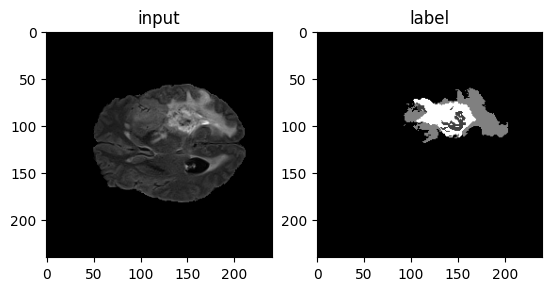

In [61]:
# 불러온 이미지 시각화 (가운데 슬라이스만)
plt.subplot(122)
plt.imshow(label[:,:,77,:].reshape(240,240), cmap='gray')
plt.title('label')

plt.subplot(121)
plt.imshow(input[:,:,77,:].reshape(240,240), cmap='gray')
plt.title('input')

plt.show()

# 3-2.Transform

- ToTensor : numpy에서 tensor로 데이터 type을 변경
- Normalization : 데이터 정규화
- RandomFlip : 랜덤 좌우 및 상하 반전
- ResizeImage : 이미지 사이즈 변경

In [ ]:
!pip install elasticdeform

In [52]:
# 트렌스폼 구현하기
from scipy.ndimage import rotate
import elasticdeform
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms

class ToTensor(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        # 채널 차원 순서 변경 : (높이, 너비, 깊이, 채널) -> (채널, 높이, 너비, 깊이)
        label = label.transpose((3, 0, 1, 2)).astype(np.float32)
        input = input.transpose((3, 0, 1, 2)).astype(np.float32)

        data = {'label': torch.from_numpy(label), 'input': torch.from_numpy(input)}

        return data

class Normalization(object):
    def __init__(self, mean=0.5, std=0.5):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - self.mean) / self.std

        data = {'label': label, 'input': input}

        return data


# FIXME: ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [240, 240, 155, 1] and output size of (256, 256, 155). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.
class ResizeImage:
    def __init__(self, output_size):
        self.output_size = output_size

    def __call__(self, data):
        label, input = data['label'], data['input']

        # 이미지 크기 변경
        label = torch.from_numpy(label).unsqueeze(0).unsqueeze(0)  # 배치 차원 추가
        label = F.interpolate(label, size=self.output_size, mode='bilinear', align_corners=False)
        label = label.squeeze(0).squeeze(0).numpy()  # 오류 수정

        input = torch.from_numpy(input).unsqueeze(0).unsqueeze(0)  # 배치 차원 추가
        input = F.interpolate(input, size=self.output_size, mode='bilinear', align_corners=False)
        input = input.squeeze(0).squeeze(0).numpy()  # 오류 수정

        data = {'label': label, 'input': input}

        return data

class MinMaxNormalization(object):
    def __init__(self, min_val=0, max_val=1):
        self.min_val = min_val
        self.max_val = max_val

    def __call__(self, data):
        label, input = data['label'], data['input']

        input = (input - input.min()) / (input.max() - input.min())
        input = input * (self.max_val - self.min_val) + self.min_val

        data = {'label': label, 'input': input}

        return data

class FlipRot(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        # rotation [0, 45]
        if np.random.rand() > 0.5:
          angle = 45
          label = rotate(label, angle, reshape=False, mode="nearest")
          input = rotate(input, angle, reshape=False, mode="nearest")

        # 수평 뒤집기
        if np.random.rand() > 0.5:
            label = np.flipud(label)
            input = np.flipud(input)

        data = {'label': label, 'input': input}

        return data

class GammaCorrection(object): #3d 버전으로 수정완료
    def __call__(self, data):
        label, input = data['label'], data['input']

        input = np.zeros(input.shape)

        for c in range(input.shape[-1]):
          im = input[:,:,:,c]
          gain, gamma = (1.2 - 0.4) * np.random.random_sample(2,) + 0.4
          im_new = np.sign(im)*gain*(np.abs(im)**gamma)
          input[:,:,:,c] = im_new

        data = {'label': label, 'input': input}

        return data


class ElasticDeformation(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        input, label = elasticdeform.deform_random_grid([input, label], sigma=2, axis=[(0, 1, 2), (0, 1, 2)], order=[1, 0], mode='constant')

        data = {'label': label, 'input': input}

        return data


class FlipRot3D(object):
    def __call__(self, data):
        label, input = data['label'], data['input']

        flip_choice = np.random.randint(3)

        if flip_choice == 0: # x축 flip
          label, input = label[::-1, :, :], input[::-1, :, :, :]
        if flip_choice == 1: # y축 flip
          label, input = label[:, ::-1, :], input[:, ::-1, :, :]
        if flip_choice == 2: # z축 flip
          label, input = label[:, :, ::-1], input[:, :, ::-1, :]

        rotate_choice = np.random.randint(2)
        if rotate_choice == 0:
          angle = np.random.randint(91)  # 0~90도로 무작위 회전할지, 특정 angle을 정할지
          label, input = rotate(label, angle), rotate(input, angle)

        data = {'label': label, 'input': input}

        return data

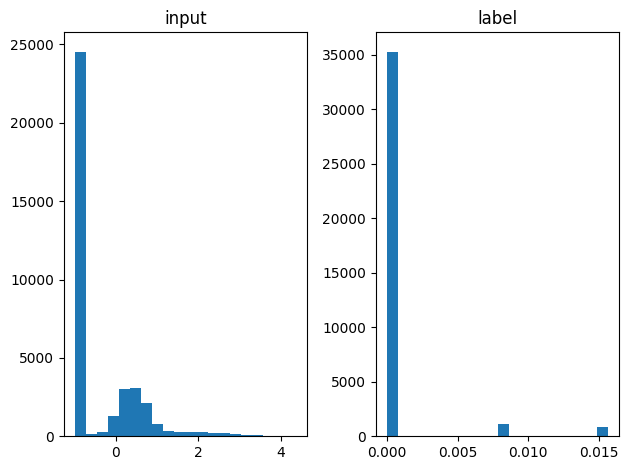

In [74]:
# 트랜스폼 잘 구현되었는지 확인(FlipRot3D,GammaCorrection,Normalization,ToTensor)
#-> gammacorrection 코드 확인 필요 : 감마 범위를 랜덤으로 갖게 해서 그런가
transform = transforms.Compose([FlipRot3D(),
                                #GammaCorrection(),
                                Normalization(mean=0.5, std=0.5),
                                ToTensor()])
dataset_train = Dataset(data_dir=dir_save_train, transform=transform)
data = dataset_train.__getitem__(0) # 한 이미지 불러오기
input = data['input'][:,:,77]
label = data['label'][:,:,77]

# 불러온 이미지 시각화
plt.subplot(122)
plt.hist(label.flatten(), bins=20)
plt.title('label')

plt.subplot(121)
plt.hist(input.flatten(), bins=20)
plt.title('input')

plt.tight_layout()
plt.show()

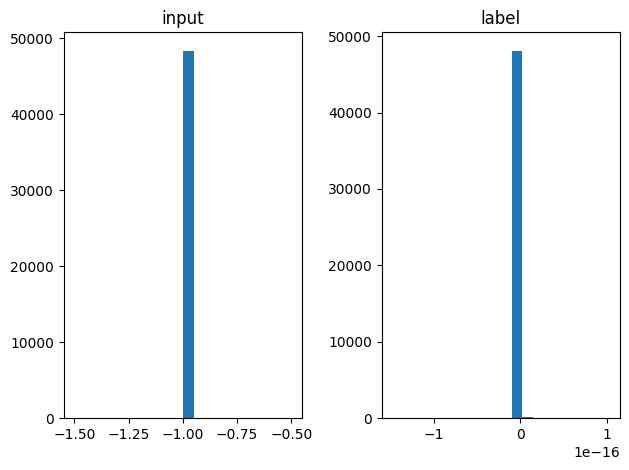

In [75]:
# 트랜스폼 잘 구현되었는지 확인(FlipRot3D,ElasticDeformation,GammaCorrection,Normalization,ToTensor)
transform = transforms.Compose([FlipRot3D(),
                                ElasticDeformation(),
                                #GammaCorrection(),
                                Normalization(mean=0.5, std=0.5),
                                ToTensor()])
dataset_train = Dataset(data_dir=dir_save_train, transform=transform)
data = dataset_train.__getitem__(0) # 한 이미지 불러오기
input = data['input'][:,:,77]
label = data['label'][:,:,77]

# 불러온 이미지 시각화
plt.subplot(122)
plt.hist(label.flatten(), bins=20)
plt.title('label')

plt.subplot(121)
plt.hist(input.flatten(), bins=20)
plt.title('input')

plt.tight_layout()
plt.show()


## 4. 네트워크 저장/불러오는 함수 정의하기

In [1]:
## 네트워크 저장하기
def save(ckpt_dir, net, optim, epoch):
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    torch.save({'net': net.state_dict(), 'optim': optim.state_dict()},
               "%s/model_epoch%d.pth" % (ckpt_dir, epoch))

## 네트워크 불러오기
def load(ckpt_dir, net, optim):
    if not os.path.exists(ckpt_dir):
        epoch = 0
        return net, optim, epoch

    ckpt_lst = os.listdir(ckpt_dir)
    ckpt_lst.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

    dict_model = torch.load('%s/%s' % (ckpt_dir, ckpt_lst[-1]))

    net.load_state_dict(dict_model['net'])
    optim.load_state_dict(dict_model['optim'])
    epoch = int(ckpt_lst[-1].split('epoch')[1].split('.pth')[0])

    return net, optim, epoch

## 5. 네트워크 훈련하기

In [2]:
# 훈련 파라미터 설정하기
param = {
    "model": "tsnet", # unet, tsnet
    "aug": "fegn", # 아래 transform에 맞게 변경
    "device": "cpu",
    "loss": "BCE", # "MSE", "BCE"
    "optimizer": "Adam", # (Adam, SGD)
    "scheduler": "LambdaLR_0.995", #(None,LambdaLR_[계수], MultiplicativeLR_[계수], StepLR_[step_size]_[gamma])
    "learning_rate": 1e-3,
    "training_epochs": 20,
    "batch_size": 4,
    "num_workers": 0
    }

base_dir = f'./runs/{param["model"]}_{param["aug"]}_{param["loss"]}_{param["optimizer"]}_{param["scheduler"]}_{param["learning_rate"]}_{param["training_epochs"]}_{param["batch_size"]}'
data_dir = dir_data
ckpt_dir = os.path.join(base_dir, "checkpoint")
log_dir = os.path.join(base_dir, "log")



NameError: name 'dir_data' is not defined

In [ ]:

# dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=transform)
# loader_train = DataLoader(dataset_train, batch_size=param["batch_size"], shuffle=True, num_workers=param["num_workers"])

# dataset_val = Dataset(data_dir=os.path.join(data_dir, 'val'), transform=transform)
# loader_val = DataLoader(dataset_val, batch_size=param["batch_size"], shuffle=False, num_workers=param["num_workers"])

# 훈련을 위한 Transform과 DataLoader
# transform = transforms.Compose([ToTensor(),
#                                 # Normalization(mean=0.5, std=0.5),
#                                 # FlipRot(),
#                                 GammaCorrection(gamma_range=(0.4, 1.2)),
#                                 ResizeImage(output_size=(512,512)),
#                                 MinMaxNormalization()])
transform = transforms.Compose([FlipRot(),
                                ElasticDeformation(),
                                GammaCorrection(gamma_range=(0.4, 1.2)),
                                ResizeImage(output_size=(256, 256, 155)),
                                Normalization(mean=0.5, std=0.5),
                                ToTensor()])

# Whole Tumor Dataset
dataset_train_whole_tumor = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=transform)
loader_train_whole_tumor = DataLoader(dataset_train_whole_tumor, batch_size=param["batch_size"], shuffle=True, num_workers=param["num_workers"])

dataset_val_whole_tumor = Dataset(data_dir=os.path.join(data_dir, 'val'), transform=transform)
loader_val_whole_tumor = DataLoader(dataset_val_whole_tumor, batch_size=param["batch_size"], shuffle=False, num_workers=param["num_workers"])

# Tumor Core Dataset
dataset_train_tumor_core = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=transform)
loader_train_tumor_core = DataLoader(dataset_train_tumor_core, batch_size=param["batch_size"], shuffle=True, num_workers=param["num_workers"])

dataset_val_tumor_core = Dataset(data_dir=os.path.join(data_dir, 'val'), transform=transform)
loader_val_tumor_core = DataLoader(dataset_val_tumor_core, batch_size=param["batch_size"], shuffle=False, num_workers=param["num_workers"])

# Enhancing Tumor Core Dataset
dataset_train_enhancing_tumor_core = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=transform)
loader_train_enhancing_tumor_core = DataLoader(dataset_train_enhancing_tumor_core, batch_size=param["batch_size"], shuffle=True, num_workers=param["num_workers"])

dataset_val_enhancing_tumor_core = Dataset(data_dir=os.path.join(data_dir, 'val'), transform=transform)
loader_val_enhancing_tumor_core = DataLoader(dataset_val_enhancing_tumor_core, batch_size=param["batch_size"], shuffle=False, num_workers=param["num_workers"])



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 네트워크 생성하기
if param["model"] == "unet":
    net_whole_tumor = UNet().to(device)
    net_tumor_core = UNet().to(device)
    net_enhancing_tumor_core = UNet().to(device)
elif param["model"] == "tsnet":
    net_whole_tumor = make_TS_Net().to(device)
    net_tumor_core = make_TS_Net().to(device)
    net_enhancing_tumor_core = make_TS_Net().to(device)

# Define the loss function and optimizer
if param["loss"] == "MSE":
    fn_loss = nn.MSELoss().to(device)
elif param["loss"] == "BCE":
    fn_loss = nn.BCEWithLogitsLoss().to(device)
else:
    print("올바른 loss function을 설정해주세요. (MSE)")

# Optimizer 설정하기
if param["optimizer"] == "Adam":
    optim_whole_tumor = torch.optim.Adam(net_whole_tumor.parameters(), lr=param["learning_rate"])
    optim_tumor_core = torch.optim.Adam(net_tumor_core.parameters(), lr=param["learning_rate"])
    optim_enhancing_tumor_core = torch.optim.Adam(net_enhancing_tumor_core.parameters(), lr=param["learning_rate"])
elif param["optimizer"] == "SGD":
    optim_whole_tumor = torch.optim.SGD(net_whole_tumor.parameters() , lr=param["learning_rate"])
    optim_tumor_core = torch.optim.SGD(net_tumor_core.parameters() , lr=param["learning_rate"])
    optim_enhancing_tumor_core = torch.optim.SGD(net_enhancing_tumor_core.parameters() , lr=param["learning_rate"])
else:
    print("올바른 optimizer를 입력해 주세요. (Adam, SGD)")

# Scheduler 설정하기
if param["scheduler"] == "None":
    scheduler_whole_tumor = False
    scheduler_tumor_core = False
    scheduler_enhancing_tumor_core = False
elif param["scheduler"].split("_")[0] == "LambdaLR":
    lambda_coefficient = float(param["scheduler"].split("_")[1])
    scheduler_whole_tumor = torch.optim.lr_scheduler.LambdaLR(optimizer=optim_whole_tumor, lr_lambda=lambda epoch: lambda_coefficient ** epoch)
    scheduler_tumor_core = torch.optim.lr_scheduler.LambdaLR(optimizer=optim_tumor_core, lr_lambda=lambda epoch: lambda_coefficient ** epoch)
    scheduler_enhancing_tumor_core = torch.optim.lr_scheduler.LambdaLR(optimizer=optim_enhancing_tumor_core, lr_lambda=lambda epoch: lambda_coefficient ** epoch)
elif param["scheduler"].split("_")[0] == "MultiplicativeLR":
    lambda_coefficient = float(param["scheduler"].split("_")[1])
    scheduler_whole_tumor = torch.optim.lr_scheduler.MultiplicativeLR(optimizer=optim_whole_tumor, lr_lambda=lambda epoch: lambda_coefficient ** epoch)
    scheduler_tumor_core = torch.optim.lr_scheduler.MultiplicativeLR(optimizer=optim_tumor_core, lr_lambda=lambda epoch: lambda_coefficient ** epoch)
    scheduler_enhancing_tumor_core = torch.optim.lr_scheduler.MultiplicativeLR(optimizer=optim_enhancing_tumor_core, lr_lambda=lambda epoch: lambda_coefficient ** epoch)
elif param["scheduler"].split("_")[0] == "StepLR":
    param_scheduler = param["scheduler"].split("_")
    step_size = int(param_scheduler[1])
    gamma = float(param_scheduler[2])
    scheduler_whole_tumor = torch.optim.lr_scheduler.StepLR(optim_whole_tumor, step_size=step_size, gamma=gamma)
    scheduler_tumor_core = torch.optim.lr_scheduler.StepLR(optim_tumor_core, step_size=step_size, gamma=gamma)
    scheduler_enhancing_tumor_core = torch.optim.lr_scheduler.StepLR(optim_enhancing_tumor_core, step_size=step_size, gamma=gamma)
else:
    scheduler_whole_tumor = False
    scheduler_tumor_core = False
    scheduler_enhancing_tumor_core = False
    print("올바른 스케줄러를 입력하세요. (None, LambdaLR_[계수], MultiplicativeLR_[계수], StepLR_[step_size]_[gamma])")


# 그밖에 부수적인 variables 설정하기
num_data_train = len(dataset_train_whole_tumor)
num_data_val = len(loader_train_whole_tumor)

num_batch_train = np.ceil(num_data_train / param["batch_size"])
num_batch_val = np.ceil(num_data_val / param["batch_size"])

# 그 밖에 부수적인 functions 설정하기
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1)
fn_denorm = lambda x, mean, std: (x * std) + mean
fn_class = lambda x: 1.0 * (x > 0.5)

In [ ]:
# Tensorboard 를 사용하기 위한 SummaryWriter 설정
writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))

In [ ]:
# 네트워크 학습시키기
st_epoch = 0
# 학습한 모델이 있을 경우 모델 로드하기
# net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

In [ ]:
def crop_input_based_on_output(input_image, output_whole_tumor, label_whole_tumor, threshold=0.5):
    # 이 함수에서 input_image는 첫 번째 모델의 입력 이미지입니다.
    # output_whole_tumor는 첫 번째 모델의 출력입니다.
    # label_whole_tumor는 첫 번째 모델의 정답 레이블입니다.
    # threshold는 임계값으로, 기본값은 0.5입니다.

    # 여기서 output_whole_tumor를 기반으로 입력 이미지를 잘라내거나 크기를 조정하여
    # 두 번째 모델인 tumor core 모델의 입력으로 생성합니다.

    # 예시: output_whole_tumor를 기준으로 입력 이미지를 crop하는 방법
    # 예시에서는 output_whole_tumor가 바이너리 세그멘테이션 맵으로 가정합니다.
    # 세그멘테이션 맵을 기반으로 입력 이미지를 crop하여 반환합니다.

    # 세그멘테이션 맵에서 유효한 영역을 가져옵니다.
    valid_area = output_whole_tumor > threshold

    # 세그멘테이션 맵을 기반으로 입력 이미지를 crop합니다.
    # 여기서는 PyTorch의 indexing을 사용하여 crop할 수 있습니다.
    cropped_input_image = input_image[:, valid_area]

    # 반환된 crop된 이미지를 tumor core 모델의 입력으로 사용합니다.
    return cropped_input_image, label_whole_tumor[:, valid_area]  # label_whole_tumor도 동일한 영역으로 잘라내어야 합니다.

In [ ]:
def train_model(net, optimizer, scheduler, data_loader, writer, epoch, phase):
    net.train() if phase == 'train' else net.eval()
    loss_arr = []

    for batch, data in enumerate(data_loader, 1):
        label = data['label'].to(device)
        input = data['input'].to(device)

        output = net(input)

        if phase == 'train':
            optimizer.zero_grad()

        loss = fn_loss(output, label)
        if phase == 'train':
            loss.backward()
            optimizer.step()

        loss_arr += [loss.item()]

        print("%s: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
              (phase.upper(), epoch, param["training_epochs"], batch, len(data_loader), np.mean(loss_arr)), end="")
        if scheduler and phase == 'train':
            print(" | LR",*scheduler.get_last_lr())
        elif phase == 'train':
            print(" | LR",optimizer.param_groups[0]['lr'])
        else:
            print()

        label = fn_tonumpy(label)
        input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
        output = fn_tonumpy(fn_class(output))

        writer.add_image('label', label, len(data_loader) * (epoch - 1) + batch, dataformats='NHWC')
        writer.add_image('input', input, len(data_loader) * (epoch - 1) + batch, dataformats='NHWC')
        writer.add_image('output', output, len(data_loader) * (epoch - 1) + batch, dataformats='NHWC')
    if scheduler and phase == 'train':
      scheduler.step()
      writer.add_scalar('learning_rate', *scheduler.get_last_lr())
    elif phase == 'train':
      writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'])
    writer.add_scalar('loss', np.mean(loss_arr), epoch)


# Training loop
for epoch in range(st_epoch + 1, param["training_epochs"] + 1):
    train_model(net_whole_tumor, optim_whole_tumor, scheduler_whole_tumor, loader_train_whole_tumor, writer_train, epoch, 'train')
    train_model(net_whole_tumor, None, None, loader_val_whole_tumor, writer_val, epoch, 'val')

    # Apply crop and forward the cropped output to the next model
    loader_train_tumor_core.dataset.update_cropped_data(net_whole_tumor)
    train_model(net_tumor_core, optim_tumor_core, scheduler_tumor_core, loader_train_tumor_core, writer_train, epoch, 'train')
    train_model(net_tumor_core, None, None, loader_val_tumor_core, writer_val, epoch, 'val')

    # Apply crop and forward the cropped output to the next model
    loader_train_enhancing_tumor_core.dataset.update_cropped_data(net_tumor_core)
    train_model(net_enhancing_tumor_core, optim_enhancing_tumor_core, scheduler_enhancing_tumor_core, loader_train_enhancing_tumor_core, writer_train, epoch, 'train')
    train_model(net_enhancing_tumor_core, None, None, loader_val_enhancing_tumor_core, writer_val, epoch, 'val')

    # Save models every 50 epochs
    if epoch % 50 == 0:
        save(ckpt_dir=ckpt_dir, net=net_whole_tumor, optim=optim_whole_tumor, epoch=epoch)
        save(ckpt_dir=ckpt_dir, net=net_tumor_core, optim=optim_tumor_core, epoch=epoch)
        save(ckpt_dir=ckpt_dir, net=net_enhancing_tumor_core, optim=optim_enhancing_tumor_core, epoch=epoch)

# Close writers
writer_train.close()
writer_val.close()

/var/folders/3c/tqn138d95dz87nrgybs0rgfw0000gn/T/ipykernel_85724/4164661479.py:98: RuntimeWarning: invalid value encountered in power
  input = input ** gamma


ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [240, 240, 155, 1] and output size of (256, 256, 155). Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

In [ ]:
def train_model(net, optimizer, scheduler, data_loader, writer, epoch, phase):
    net.train() if phase == 'train' else net.eval()
    loss_arr = []

    for batch, data in enumerate(data_loader, 1):
        label = data['label'].to(device)
        input = data['input'].to(device)

        if phase == 'train':
            optimizer.zero_grad()

        output = net(input)

        # If in training phase, use output for the next model
        if phase == 'train':
            cropped_input = crop_input_based_on_output(input, output)
            next_model_output = net(cropped_input)
            loss = fn_loss(next_model_output, label)
            loss.backward()
            optimizer.step()
        else:
            loss = fn_loss(output, label)

        loss_arr += [loss.item()]

        print("%s: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
              (phase.upper(), epoch, param["training_epochs"], batch, len(data_loader), np.mean(loss_arr)), end="")
        if scheduler and phase == 'train':
            print(" | LR",*scheduler.get_last_lr())
        elif phase == 'train':
            print(" | LR",optimizer.param_groups[0]['lr'])
        else:
            print()

        label = fn_tonumpy(label)
        input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
        output = fn_tonumpy(fn_class(output))

        writer.add_image('label', label, len(data_loader) * (epoch - 1) + batch, dataformats='NHWC')
        writer.add_image('input', input, len(data_loader) * (epoch - 1) + batch, dataformats='NHWC')
        writer.add_image('output', output, len(data_loader) * (epoch - 1) + batch, dataformats='NHWC')
    if scheduler and phase == 'train':
      scheduler.step()
      writer.add_scalar('learning_rate', *scheduler.get_last_lr())
    elif phase == 'train':
      writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'])
    writer.add_scalar('loss', np.mean(loss_arr), epoch)


# Training loop
for epoch in range(st_epoch + 1, param["training_epochs"] + 1):
    train_model(net_whole_tumor, optim_whole_tumor, scheduler_whole_tumor, loader_train_whole_tumor, writer_train, epoch, 'train')
    train_model(net_whole_tumor, None, None, loader_val_whole_tumor, writer_val, epoch, 'val')

    # Train and validate tumor core model
    train_model(net_tumor_core, optim_tumor_core, scheduler_tumor_core, loader_train_tumor_core, writer_train, epoch, 'train')
    train_model(net_tumor_core, None, None, loader_val_tumor_core, writer_val, epoch, 'val')

    # Train and validate enhancing tumor core model
    train_model(net_enhancing_tumor_core, optim_enhancing_tumor_core, scheduler_enhancing_tumor_core, loader_train_enhancing_tumor_core, writer_train, epoch, 'train')
    train_model(net_enhancing_tumor_core, None, None, loader_val_enhancing_tumor_core, writer_val, epoch, 'val')

    # Save models every 50 epochs
    if epoch % 50 == 0:
        save(ckpt_dir=ckpt_dir, net=net_whole_tumor, optim=optim_whole_tumor, epoch=epoch)
        save(ckpt_dir=ckpt_dir, net=net_tumor_core, optim=optim_tumor_core, epoch=epoch)
        save(ckpt_dir=ckpt_dir, net=net_enhancing_tumor_core, optim=optim_enhancing_tumor_core, epoch=epoch)

# Close writers
writer_train.close()
writer_val.close()


In [ ]:
# 첫번째 모델의 출력을 사용하여 두번째 모델의 입력을 생성하고 학습, 두번째 모델의 출력을 사용하여 세번째 모델의 입력을 생성하고 학습
for epoch in range(st_epoch + 1, param["training_epochs"] + 1):
    net_whole_tumor.train()
    net_tumor_core.train()
    net_enhancing_tumor_core.train()  # Enhancing tumor core 모델도 학습 상태로 설정
    loss_arr_whole_tumor = []
    loss_arr_tumor_core = []
    loss_arr_enhancing_tumor_core = []

    for batch, data in enumerate(loader_train_whole_tumor, 1):
        # forward pass
        label_whole_tumor = data['label'].to(device)
        input_whole_tumor = data['input'].to(device)

        # Get output of whole tumor model
        output_whole_tumor = net_whole_tumor(input_whole_tumor)

        # Crop input based on whole tumor model output
        input_tumor_core, label_tumor_core = crop_input_based_on_output(input_whole_tumor, label_whole_tumor, output_whole_tumor)

        # Forward pass for tumor core model
        output_tumor_core = net_tumor_core(input_tumor_core)

        # Crop input based on tumor core model output
        input_enhancing_tumor_core, label_enhancing_tumor_core = crop_input_based_on_output(input_tumor_core, label_tumor_core, output_tumor_core)

        # Forward pass for enhancing tumor core model
        output_enhancing_tumor_core = net_enhancing_tumor_core(input_enhancing_tumor_core)

        # Backward pass for enhancing tumor core model
        optim_enhancing_tumor_core.zero_grad()
        loss_enhancing_tumor_core = fn_loss(output_enhancing_tumor_core, label_enhancing_tumor_core)
        loss_enhancing_tumor_core.backward()
        optim_enhancing_tumor_core.step()

        # Backward pass for tumor core model
        optim_tumor_core.zero_grad()
        loss_tumor_core = fn_loss(output_tumor_core, label_tumor_core)
        loss_tumor_core.backward()
        optim_tumor_core.step()

        # Backward pass for whole tumor model
        optim_whole_tumor.zero_grad()
        loss_whole_tumor = fn_loss(output_whole_tumor, label_whole_tumor)
        loss_whole_tumor.backward()
        optim_whole_tumor.step()

        loss_arr_whole_tumor.append(loss_whole_tumor.item())
        loss_arr_tumor_core.append(loss_tumor_core.item())
        loss_arr_enhancing_tumor_core.append(loss_enhancing_tumor_core.item())

        print("TRAIN: EPOCH %04d / %04d | BATCH %04d / %04d | WT_LOSS %.4f | TC_LOSS %.4f | ETC_LOSS %.4f" %
              (epoch, param["training_epochs"], batch, len(loader_train_whole_tumor), np.mean(loss_arr_whole_tumor), np.mean(loss_arr_tumor_core), np.mean(loss_arr_enhancing_tumor_core)))

        # Tensorboard 저장하기
        if param["scheduler"] != "None":
            scheduler_whole_tumor.step()
            scheduler_tumor_core.step()
            scheduler_enhancing_tumor_core.step()
            writer_train.add_scalar('learning_rater_whole_tumor', *scheduler_whole_tumor.get_last_lr())
            writer_train.add_scalar('learning_rate_tumor_core', *scheduler_tumor_core.get_last_lr())
            writer_train.add_scalar('learning_rater_enhancing_tumor_core', *scheduler_enhancing_tumor_core.get_last_lr())
        else:
            writer_train.add_scalar('learning_rater_whole_tumor', optim_whole_tumor.param_groups[0]['lr'])
            writer_train.add_scalar('learning_rate_tumor_core', optim_tumor_core.param_groups[0]['lr'])
            writer_train.add_scalar('learning_rater_enhancing_tumor_core', optim_enhancing_tumor_core.param_groups[0]['lr'])
        writer_train.add_scalar('loss_whole_tumor', np.mean(loss_arr_whole_tumor), epoch)
        writer_train.add_scalar('loss_tumor_core', np.mean(loss_arr_tumor_core), epoch)
        writer_train.add_scalar('loss_enhancing_tumor_core', np.mean(loss_arr_enhancing_tumor_core), epoch)

    # 이하 validation 코드도 위와 동일한 방식으로 수정
    # 생략


## 6. 훈련된 모델 테스트하기

In [ ]:
# TODO: Validation 코드 수정

transform = transforms.Compose([ToTensor(),
                                ResizeImage(output_size=(512,512)),
                                MinMaxNormalization()])

dataset_test = Dataset(data_dir=os.path.join(data_dir, 'test'), transform=transform)
loader_test = DataLoader(dataset_test, batch_size=param["batch_size"], shuffle=False, num_workers=param["num_workers"])

# 그밖에 부수적인 variables 설정하기
num_data_test = len(dataset_test)
num_batch_test = np.ceil(num_data_test / param["batch_size"])

# 결과 디렉토리 생성하기
result_dir = os.path.join(base_dir, 'result')
if not os.path.exists(result_dir):
    os.makedirs(os.path.join(result_dir, 'png'))
    os.makedirs(os.path.join(result_dir, 'numpy'))


net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

with torch.no_grad():
      net.eval()
      loss_arr = []

      for batch, data in enumerate(loader_test, 1):
          # forward pass
          label = data['label'].to(device)
          input = data['input'].to(device)

          output = net(input)

          # 손실함수 계산하기
          loss = fn_loss(output, label)
          loss_arr += [loss.item()]

          print("TEST: BATCH %04d / %04d | LOSS %.4f" %
                (batch, num_batch_test, np.mean(loss_arr)))

          # Tensorboard 저장하기
          label = fn_tonumpy(label)
          input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
          output = fn_tonumpy(fn_class(output))

          # 테스트 결과 저장하기
          for j in range(label.shape[0]):
              id = num_batch_test * (batch - 1) + j

              plt.imsave(os.path.join(result_dir, 'png', 'label_%04d.png' % id), label[j].squeeze(), cmap='gray')
              plt.imsave(os.path.join(result_dir, 'png', 'input_%04d.png' % id), input[j].squeeze(), cmap='gray')
              plt.imsave(os.path.join(result_dir, 'png', 'output_%04d.png' % id), output[j].squeeze(), cmap='gray')

              np.save(os.path.join(result_dir, 'numpy', 'label_%04d.npy' % id), label[j].squeeze())
              np.save(os.path.join(result_dir, 'numpy', 'input_%04d.npy' % id), input[j].squeeze())
              np.save(os.path.join(result_dir, 'numpy', 'output_%04d.npy' % id), output[j].squeeze())

print("AVERAGE TEST: BATCH %04d / %04d | LOSS %.4f" %
        (batch, num_batch_test, np.mean(loss_arr)))

## 7. 결과 시각화하기

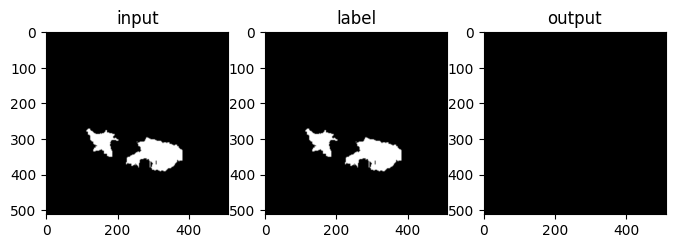

In [ ]:
##
lst_data = os.listdir(os.path.join(result_dir, 'numpy'))

lst_label = [f for f in lst_data if f.startswith('label')]
lst_input = [f for f in lst_data if f.startswith('input')]
lst_output = [f for f in lst_data if f.startswith('output')]

lst_label.sort()
lst_input.sort()
lst_output.sort()

##
id = 0

label = np.load(os.path.join(result_dir,"numpy", lst_label[id]))
input = np.load(os.path.join(result_dir,"numpy", lst_input[id]))
output = np.load(os.path.join(result_dir,"numpy", lst_output[id]))

## 플롯 그리기
plt.figure(figsize=(8,6))
plt.subplot(131)
plt.imshow(input, cmap='gray')
plt.title('input')

plt.subplot(132)
plt.imshow(label, cmap='gray')
plt.title('label')

plt.subplot(133)
plt.imshow(output, cmap='gray')
plt.title('output')

plt.show()
